In [1]:
# Initialization
%load_ext autoreload
%autoreload 2
import sys
import os
import pathlib

# To be able to reference packages/modules in this repository, this
# relative path must be added to the python path. Your notebook may be 
# in a different folder, so modify this variable to point to the src 
# folder.
proj_notebooks_root = pathlib.Path().absolute()
proj_root_path = proj_notebooks_root.parent
data_path = proj_root_path / "data"

if proj_root_path not in sys.path:
    sys.path.insert(0, proj_root_path.as_posix())
    print("Updated Python Path")

print(f"Project Root Path: {proj_root_path}")
print(f"Project Source Root Path: {proj_notebooks_root}")
print(f"Project Data Path: {data_path}")

Updated Python Path
Project Root Path: /home/default/workspace/roadsegm
Project Source Root Path: /home/default/workspace/roadsegm/ActiveLearning
Project Data Path: /home/default/workspace/roadsegm/data


In [2]:
# !pip install --user kaggle

In [3]:
# !mkdir /home/default/.kaggle/
# !touch /home/default/.kaggle/kaggle.json

# api_token = {"username":"username","key":"key"}

# import json

# with open('/home/default/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json


# !sudo apt-get update
# !sudo apt-get install unzip


In [4]:
!kaggle datasets download --help

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
usage: kaggle datasets download [-h] [-f FILE_NAME] [-p PATH] [-w] [--unzip]
                                [-o] [-q]
                                [dataset]

optional arguments:
  -h, --help            show this help message and exit
  dataset               Dataset URL suffix in format <owner>/<dataset-name> (use "kaggle datasets list" to show options)
  -f FILE_NAME, --file FILE_NAME
                        File name, all files downloaded if not provided
                        (use "kaggle datasets files -d <dataset>" to show options)
  -p PATH, --path PATH  Folder where file(s) will be downloaded, defaults to current working directory
  -w, --wp              Download files to current working path
  --unzip               Unzip the downloaded file. Will de

In [5]:
base_dir = data_path / 'crack_segmentation_dataset'
if not base_dir.exists():
    ! kaggle datasets download -p {data_path.as_posix()} -d lakshaymiddha/crack-segmentation-dataset
    ! unzip -q {data_path / 'crack-segmentation-dataset.zip'} -d {data_path}
    ! rm {data_path / 'crack-segmentation-dataset.zip'} 
else:
    print("Found dataset at ", base_dir.as_posix())


Found dataset at  /home/default/workspace/roadsegm/data/crack_segmentation_dataset


In [6]:
f = [y for y in (base_dir).glob('*')] 
print(f"Found {len(f)} dirs in {base_dir}")

counts = {}

for i in f:
    files = [y for y in i.glob('*')] 
    num = len(files)
    counts[i.stem] = num
print(counts)
files

Found 5 dirs in /home/default/workspace/roadsegm/data/crack_segmentation_dataset
{'test': 2, 'readme': 0, 'train': 2, 'masks': 11298, 'images': 11298}


[PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/cracktree200_6240.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Volker_DSC01680_133_920_1599_1773.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Rissbilder_for_Florian_9S6A2885_240_400_3555_4056.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Rissbilder_for_Florian_9S6A3115_1837_674_2470_3120.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/CRACK500_20160318_181627_1921_721.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/noncrack_noncrack_concrete_wall_15_0.jpg.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/Rissbilder_for_Florian_9S6A2869_444_1582_3292_3830.jpg'),
 PosixPath('/home/default/workspace/roadsegm/data/crack_segmentation_dataset/images/

In [7]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import GradScaler, autocast
import torchvision
from tqdm import tqdm
from torchinfo import summary
import time

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using device: cuda



In [8]:
X_dir = base_dir/'train'/'images'
y_dir = base_dir/'train'/'masks'

X_files = [y for y in X_dir.glob('*')] 

for i in X_files:
    assert((y_dir / i.name).exists())

all_files = [(x, (y_dir / x.name)) for x in X_dir.glob('*')] 
for i in range(10):
    print(all_files[i][0].name)


cracktree200_6240.jpg
Volker_DSC01680_133_920_1599_1773.jpg
Rissbilder_for_Florian_9S6A2885_240_400_3555_4056.jpg
CRACK500_20160318_181627_1921_721.jpg
noncrack_noncrack_concrete_wall_15_0.jpg.jpg
Rissbilder_for_Florian_9S6A2869_444_1582_3292_3830.jpg
Rissbilder_for_Florian_9S6A3105_3_424_3449_4056.jpg
Rissbilder_for_Florian_9S6A2812_62_375_3665_3538.jpg
Rissbilder_for_Florian_9S6A2852_1479_510_3289_2569.jpg
GAPS384_train_0560_541_1.jpg


In [9]:
class CracksDataset(torch.utils.data.Dataset):
    def __init__(self, files,image_transforms=None, both_transforms=None):
        self.files = files
        
        self.image_transforms = image_transforms
        self.both_transforms = both_transforms
        self.segment_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.files)
    

    def __getitem__(self, idx):
        imagePath, segmentPath = self.files[idx]
        image = Image.open(imagePath)
        segment = self.segment_transforms(Image.open(segmentPath))
#         print(segment)
        
            
        if self.image_transforms is not None:
            image = self.image_transforms(image)
            
        if self.both_transforms is not None:
            image = self.both_transforms(image)
            segment = self.both_transforms(segment)
        
        return image, segment.type(torch.int64) 


In [10]:
class FocalLoss(torch.nn.Module):
    """
    References:
        Author: clcarwin
        Site https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
    """

    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = torch.nn.functional.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.data.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            select = (target != 0).type(torch.LongTensor).to(self.alpha.device)
            at = self.alpha.gather(0, select.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [11]:
data_transforms = {
    'both': transforms.Compose([
#         transforms.CenterCrop((630, 1024))
    ]),
    'images': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

all_files = all_files
random.shuffle(all_files)

train_count = len(all_files)*8//10

train_dataset = CracksDataset(all_files[:train_count],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

val_dataset = CracksDataset(all_files[train_count:],
                              image_transforms=data_transforms['images'], 
                              both_transforms=data_transforms['both'])

print(f"Created train_dataset with {len(train_dataset)} datapoints.")
print(f"Created val_dataset with {len(val_dataset)} datapoints.")


batch_size = 36
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         prefetch_factor=2,
                                         pin_memory=True,
                                         num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=8)

Created train_dataset with 7682 datapoints.
Created val_dataset with 1921 datapoints.


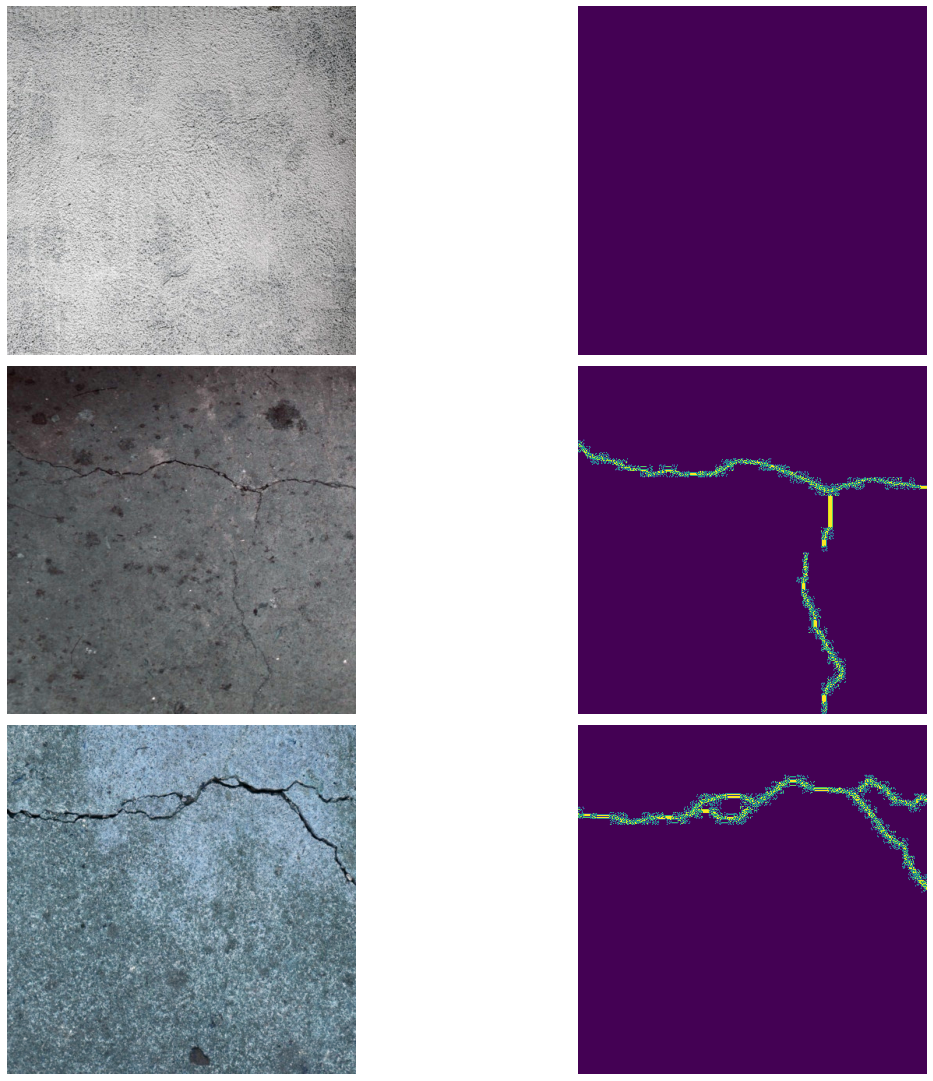

In [12]:
batch = next(iter(train_dataloader))
tensors = batch[0]
segments = batch[1]

# tensors, metadata
y = int(len(tensors)/2+0.5); x = 2
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(min(len(tensors)//2, 3)):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*2) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*2) + 2)
    image = segments[i].permute(1,2,0).cpu().numpy()
    image = np.squeeze(image)
#     image = np.atleast_3d(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


In [13]:
def get_eval_metrics(pred, gold, threshold = 0.5):
    pred = (pred > threshold).long()
    gold = gold.long()
    hits = torch.sum(torch.mul(pred, gold)).item() #element-wise multiplication
    shots = torch.sum(pred).item()
    targets = torch.sum(gold).item()
#     print(hits, shots, targets)
    return hits, shots, targets

def train_loop(dataloader, model, loss_fn, optimizer, history, lr_sched = None):
    size = len(dataloader.dataset)
    model.train()
    loss_sum = 0
    bar_format = "{l_bar}{bar} {elapsed}<{remaining} {rate_fmt}{postfix}"
    
    with tqdm(dataloader, unit="batch", bar_format=bar_format) as tepoch:
        for X, y in tepoch:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            # Runs the forward pass with autocasting.
            with autocast():
                output = model(X)
                loss = loss_fn(output, y)

            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            # Backward passes under autocast are not recommended.
            # Backward ops run in the same dtype autocast chose for corresponding forward ops.
            scaler.scale(loss).backward()

            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()
            
            loss_sum += loss.item()

            if(lr_sched is not None):
                lr_sched.step()

            loss = loss.item()
            tepoch.set_postfix(
                loss=round(loss, 4), 
                lr=round(lr_sched.get_last_lr()[0], 4)
            )
        history['train_lr'].append(lr_sched.get_last_lr()[0])
        history['train_loss'].append(loss_sum/len(dataloader))
    
    
def test_loop(dataloader, model, loss_fn, history):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    total_hits = 0
    total_shots = 0
    total_targets = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing", unit="batches"):
            X = X.to(device)
            y = y.to(device)
#             print(y.shape)
            
            output = model(X)
            
            loss += loss_fn(output, y).item()
            hits, shots, targets = get_eval_metrics(output, y)
            total_hits += hits
            total_shots += shots
            total_targets += targets

    loss /= num_batches
    history['test_loss'].append(loss)
    history['test_hits'].append(total_hits)
    history['test_shots'].append(total_shots)
    history['test_targets'].append(total_targets)
    
    if total_shots == 0:
        precision = 0
        recall = 0
        f1score = 0
    else:
        precision = total_hits/total_shots
        recall = total_hits/total_targets
        f1score = (2 * precision * recall)/(precision + recall)
        

    history['test_precision'].append(precision)
    history['test_recall'].append(recall)
    history['test_f1score'].append(f1score)
    

In [14]:
class SegModel(torch.nn.Module):

    def __init__(self, numclasses):
        super(SegModel, self).__init__()

        self.fcn = torchvision.models.segmentation.fcn_resnet50(
            weights=None, 
            num_classes = numclasses, 
            aux_loss = False,
            weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT)
#         self.softmax = torch.nn.Softmax(0)

    def forward(self, x):
        x = self.fcn(x)['out']
#         x = self.softmax(x)
        return x

In [15]:
model = SegModel(2)
model.to(device)

epochs = 10

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9)

lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                       max_lr=0.01, 
                       steps_per_epoch=len(train_dataloader), 
                       epochs=epochs)

# loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn = FocalLoss(gamma=2, alpha=0.25)


In [16]:
# Creates a GradScaler once at the beginning of training.

scaler = GradScaler()

history = {
    'train_lr':[],
    'train_loss':[],
    'test_loss':[],
    'test_hits':[],
    'test_shots':[],
    'test_targets':[],
    'test_precision': [],
    'test_recall': [],
    'test_f1score': []
}

begin = time.time()
  
for epoch in range(epochs):
    print()
    print(f'Epoch {epoch+1}')
    print("-------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, history, lr_sched)
    test_loop(val_dataloader, model, loss_fn, history)
    print(f"Training Loss: {history['train_loss'][-1]:.5}\tTesting Loss: {history['test_loss'][-1]:.5}")

end = time.time()


# watch -d -n 0.5 nvidia-smi
# Taking ~ 3 mins per epoch to train


Epoch 1
-------------


100%|██████████ 05:19<00:00  1.49s/batch, loss=0.0103, lr=0.0028
Testing: 100%|██████████| 54/54 [01:07<00:00,  1.26s/batches]


Training Loss: 0.023632	Testing Loss: 0.015139

Epoch 2
-------------


100%|██████████ 05:22<00:00  1.51s/batch, loss=0.0196, lr=0.0076
Testing: 100%|██████████| 54/54 [01:06<00:00,  1.23s/batches]


Training Loss: 0.013869	Testing Loss: 0.012649

Epoch 3
-------------


100%|██████████ 05:20<00:00  1.50s/batch, loss=0.0122, lr=0.01  
Testing: 100%|██████████| 54/54 [01:07<00:00,  1.25s/batches]


Training Loss: 0.012156	Testing Loss: 0.011561

Epoch 4
-------------


100%|██████████ 05:17<00:00  1.48s/batch, loss=0.0133, lr=0.0095
Testing: 100%|██████████| 54/54 [01:07<00:00,  1.24s/batches]


Training Loss: 0.011352	Testing Loss: 0.010966

Epoch 5
-------------


100%|██████████ 05:20<00:00  1.50s/batch, loss=0.0131, lr=0.0081
Testing: 100%|██████████| 54/54 [01:07<00:00,  1.25s/batches]


Training Loss: 0.010906	Testing Loss: 0.010568

Epoch 6
-------------


100%|██████████ 05:18<00:00  1.49s/batch, loss=0.0088, lr=0.0061
Testing: 100%|██████████| 54/54 [01:06<00:00,  1.22s/batches]


Training Loss: 0.010502	Testing Loss: 0.010308

Epoch 7
-------------


100%|██████████ 05:19<00:00  1.50s/batch, loss=0.0126, lr=0.0039
Testing: 100%|██████████| 54/54 [01:08<00:00,  1.26s/batches]


Training Loss: 0.010262	Testing Loss: 0.010068

Epoch 8
-------------


100%|██████████ 05:14<00:00  1.47s/batch, loss=0.01, lr=0.0019  
Testing: 100%|██████████| 54/54 [01:06<00:00,  1.23s/batches]


Training Loss: 0.010075	Testing Loss: 0.010161

Epoch 9
-------------


100%|██████████ 05:17<00:00  1.48s/batch, loss=0.0081, lr=0.0005
Testing: 100%|██████████| 54/54 [01:05<00:00,  1.22s/batches]


Training Loss: 0.0099891	Testing Loss: 0.0099201

Epoch 10
-------------


100%|██████████ 05:16<00:00  1.48s/batch, loss=0.0141, lr=0     
Testing: 100%|██████████| 54/54 [01:05<00:00,  1.22s/batches]

Training Loss: 0.0099252	Testing Loss: 0.0099886


In [21]:
models_dir = proj_root_path / 'models'
if not models_dir.exists():
    models_dir.mkdir()

# inf_model_name = "30-FCN-inference.pth"
ent_model_name = "01-FCN-simple-2.pth"
# torch.save(model.state_dict(), models_dir / inf_model_name)
torch.save(model, models_dir / ent_model_name)

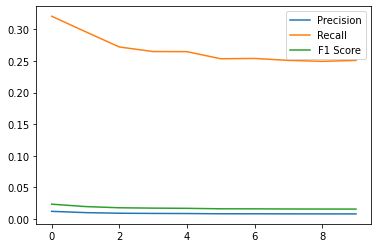

In [22]:
epochs_range = range(epochs)

plt.plot(epochs_range, history['test_precision'], label='Precision')
plt.plot(epochs_range, history['test_recall'], label='Recall')
plt.plot(epochs_range, history['test_f1score'], label='F1 Score')
plt.legend()

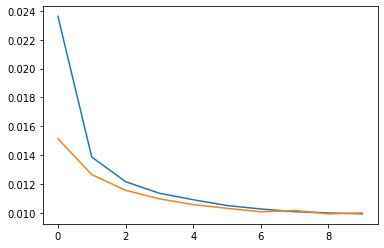

In [23]:

# plt.figure(figsize=(8,8))
# plt.subplots(1,2,1)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['test_loss'], label='Training Loss')

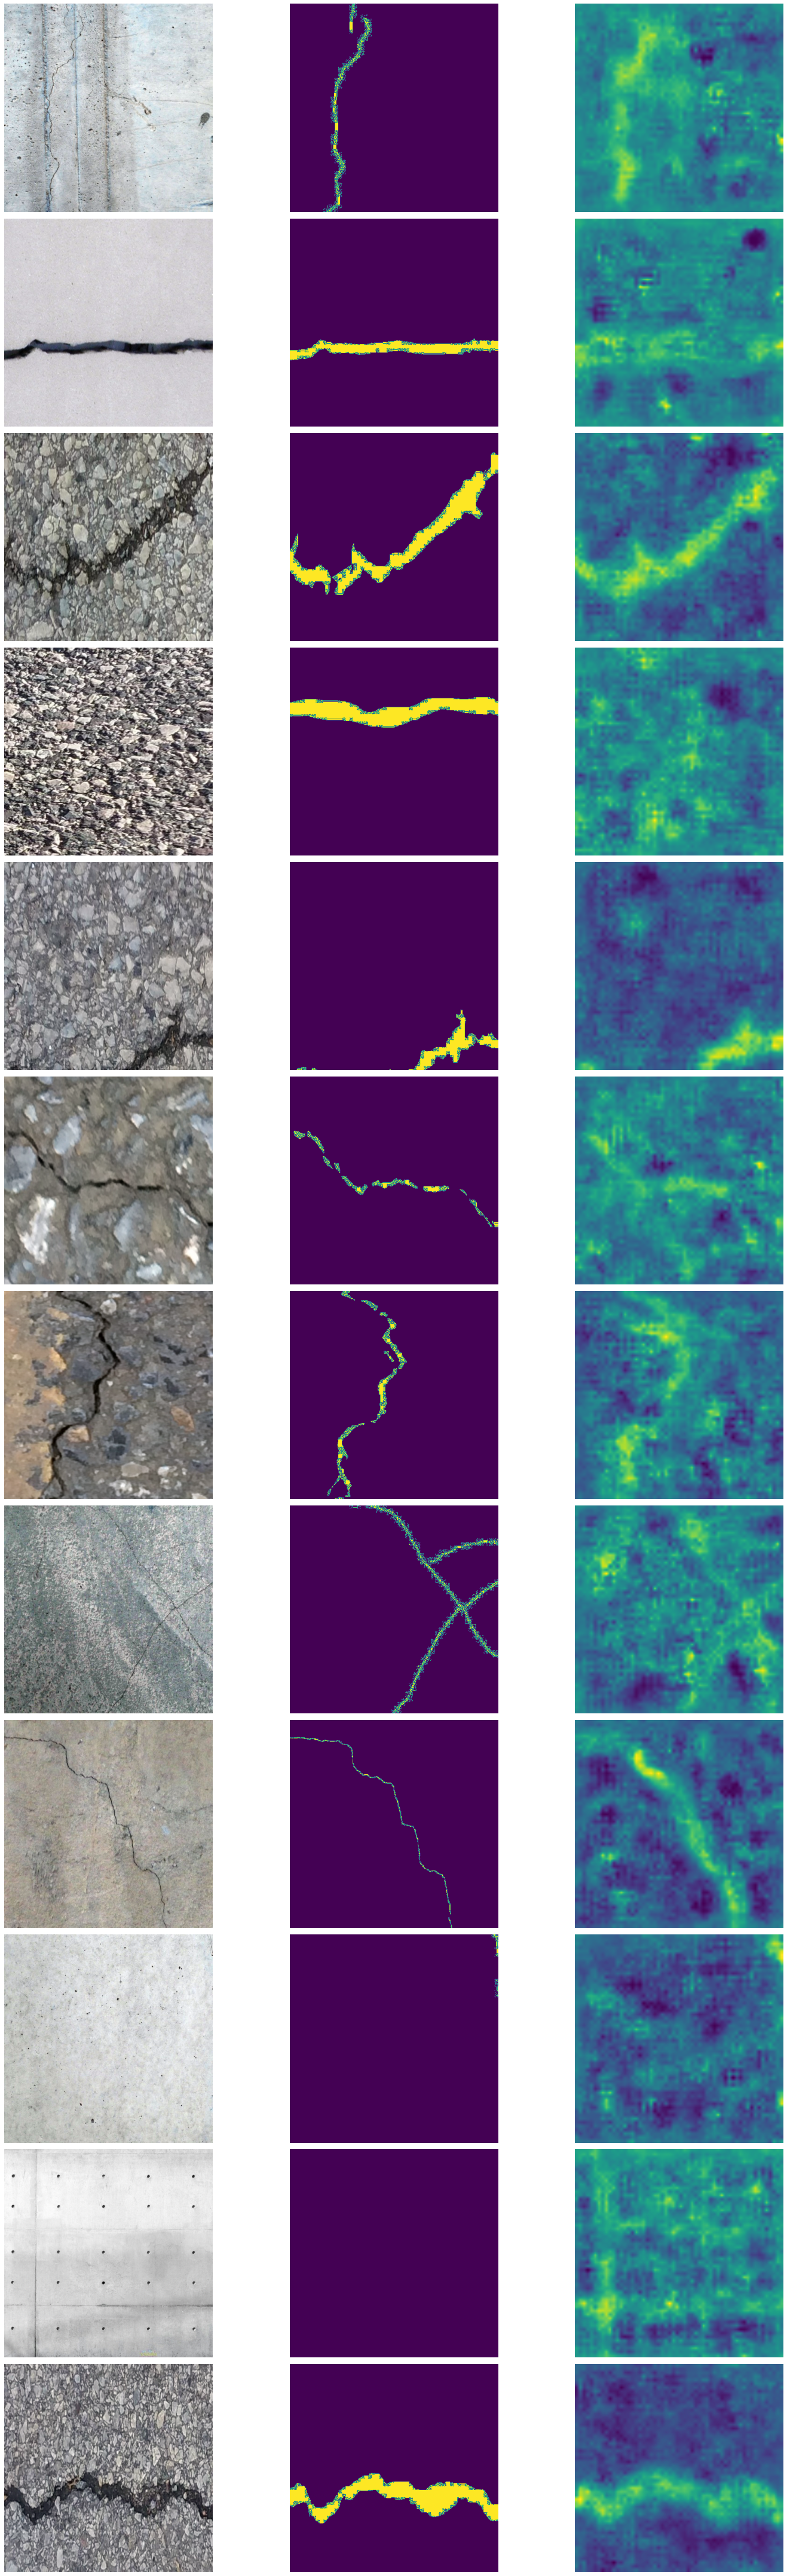

In [29]:
batch = next(iter(val_dataloader))
tensors = batch[0].to(device)
segments = batch[1]

with torch.no_grad():
    output = torch.sigmoid(model(tensors))

y = max(len(tensors)//3, 1)
x = 3
fig = plt.figure(figsize=(8*x, 5*y))

for i in range(y):
#     print(y*100 + x*10 + i)
    ax = fig.add_subplot(y , x , (i*3) + 1)
    image = tensors[i].permute(1,2,0).cpu().numpy()
    image = (image - [image[:,:,0].min(), image[:,:,1].min(), image[:,:,2].min()])
    image = image/([image[:,:,0].max(), image[:,:,1].max(), image[:,:,2].max()])
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*3) + 2)
    image = segments[i].cpu().numpy()
    image = np.squeeze(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    
    ax = fig.add_subplot(y , x , (i*3) + 3)
    image = output[i][1].cpu().numpy()
    image = np.squeeze(image)
    ax.set_axis_off()
    ax.imshow(image)
    plt.tight_layout()
    


In [ ]:
plt.hist((output[1].cpu().numpy().flatten() > 0.5).astype(int))

In [ ]:
plt.hist(segments[1].cpu().numpy().flatten())

In [ ]:
np.sum((output[1] > 0.5).cpu().numpy().astype(int) * segments[1].cpu().numpy().astype(int))

In [30]:
hits, shots, targets = get_eval_metrics(output[1].cpu(), segments[1])
precision = hits/shots
recall = hits/targets
f1score = (2 * precision * recall)/(precision + recall)

print("Hits:", hits)
print("Shots:", shots)
print("Targets:", targets)

print("Precision:",precision)
print("Recall:", recall)
print("F1 score:", f1score)

Hits: 2775
Shots: 191751
Targets: 8660
Precision: 0.014471893236541139
Recall: 0.3204387990762125
F1 score: 0.027693090698614344


In [34]:
output = torch.Tensor([1, 1, 1, 1, 0, 0, 0, 0, 0])
target = torch.Tensor([0, 1, 1, 1, 1, 1, 0, 0, 0])

hits, shots, targets = get_eval_metrics(output, target)
precision = hits/shots
recall = hits/targets
f1score = (2 * precision * recall)/(precision + recall)

print("Hits:", hits)
print("Shots:", shots)
print("Targets:", targets)

print("Precision:",precision)
print("Recall:", recall)
print("F1 score:", f1score)

Hits: 3
Shots: 4
Targets: 5
Precision: 0.75
Recall: 0.6
F1 score: 0.6666666666666665
